<a href="https://colab.research.google.com/github/fadlinisasiGit/Website-Pendeteksi-Kebersihan-Lingkungan/blob/main/Pendeteksi_Kebersihan_Lingkungan3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns




In [ ]:
# mengecek versi Tensorflow di Colab
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
!pip install opendatasets

In [ ]:
# install paket kaggle
!pip install -q kaggle

# Upload file kaggle.json dari Create New API Token Akun Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mfadliramadhan","key":"469324e883b64509a270edc4bfa15d4d"}'}

In [ ]:

import opendatasets as od
dataset_url= 'https://www.kaggle.com/mfadliramadhan/cleandirtygarbage'
od.download('https://www.kaggle.com/mfadliramadhan/cleandirtygarbage')

100%|██████████| 643M/643M [00:04<00:00, 162MB/s]


In [ ]:
# melakukan ekstraksi pada file zip
import zipfile,os

 
base_dir = '/content/cleandirtygarbage/garbage'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.listdir('/content/cleandirtygarbage/garbage/train')
os.listdir('/content/cleandirtygarbage/garbage/test')

['clean', 'dirty']

In [ ]:
# Total seluruh data
train_clean = len(os.listdir('/content/cleandirtygarbage/garbage/train/clean'))
train_dirty = len(os.listdir('/content/cleandirtygarbage/garbage/train/dirty'))
test_clean = len(os.listdir('/content/cleandirtygarbage/garbage/test/clean'))
test_dirty = len(os.listdir('/content/cleandirtygarbage/garbage/test/dirty'))

print("count data: ")
print("train clean: " + str(train_clean))
print("train dirty: " + str(train_dirty))
print("train clean: " + str(test_clean))
print("test dirty: " + str(test_dirty))
print("total: "+ str(train_clean+train_dirty+test_clean+test_dirty))

count data: 
train clean: 1207
train dirty: 1019
train clean: 600
test dirty: 600
total: 3426


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split = 0.2)

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        # karena kita merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary',
        subset = 'training')

test_generator = test_datagen.flow_from_directory(
        test_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4, # karena kita merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary',
        subset = 'validation')

Found 1782 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)

{'clean': 0, 'dirty': 1}


In [ ]:
# membangun arsitektur sebuah CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.98 and logs.get('val_accuracy')>=0.98):
      print("\nTraining Model Stopped! Accuracy Model is very good!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
# Optimizer dengan learning rate
from tensorflow.keras.optimizers import Adam

adam = Adam(lr=0.0001)

model.compile(loss = 'binary_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
      train_generator,  
      epochs=200, 
      steps_per_epoch=25,
      validation_data=test_generator,
      validation_steps=5, 
      verbose=2,
      callbacks=[callbacks])

Epoch 1/200
25/25 - 5s - loss: 0.1020 - accuracy: 0.9694 - val_loss: 0.9916 - val_accuracy: 0.8500 - 5s/epoch - 215ms/step
Epoch 2/200
25/25 - 4s - loss: 0.0446 - accuracy: 0.9800 - val_loss: 0.4766 - val_accuracy: 0.9000 - 4s/epoch - 142ms/step
Epoch 3/200
25/25 - 3s - loss: 0.0349 - accuracy: 0.9800 - val_loss: 0.6524 - val_accuracy: 0.8000 - 3s/epoch - 135ms/step
Epoch 4/200
25/25 - 3s - loss: 0.0562 - accuracy: 0.9900 - val_loss: 1.0475 - val_accuracy: 0.8000 - 3s/epoch - 137ms/step
Epoch 5/200
25/25 - 3s - loss: 0.0595 - accuracy: 0.9800 - val_loss: 1.4370 - val_accuracy: 0.7500 - 3s/epoch - 119ms/step
Epoch 6/200
25/25 - 4s - loss: 0.0779 - accuracy: 0.9600 - val_loss: 0.8554 - val_accuracy: 0.7500 - 4s/epoch - 146ms/step
Epoch 7/200
25/25 - 5s - loss: 0.0974 - accuracy: 0.9700 - val_loss: 0.1058 - val_accuracy: 0.9500 - 5s/epoch - 190ms/step
Epoch 8/200
25/25 - 4s - loss: 0.0245 - accuracy: 0.9900 - val_loss: 1.4447 - val_accuracy: 0.7500 - 4s/epoch - 141ms/step
Epoch 9/200
25/2

Saving 2c0cf982e4f4f68748945505a882d3d8e9fadd14.temp.jpeg to 2c0cf982e4f4f68748945505a882d3d8e9fadd14.temp.jpeg
2c0cf982e4f4f68748945505a882d3d8e9fadd14.temp.jpeg
kotor


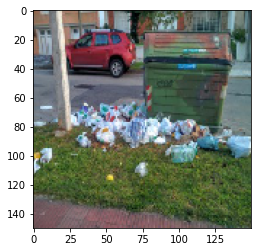

In [ ]:
# melihat hasil dari model yang telah Anda buat pada Notebook. 
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes==0:
    print('bersih')
  else:
    print('kotor')

Saving WhatsApp Image 2020-05-10 at 4.59.15 PM (2).jpeg to WhatsApp Image 2020-05-10 at 4.59.15 PM (2).jpeg
WhatsApp Image 2020-05-10 at 4.59.15 PM (2).jpeg
bersih


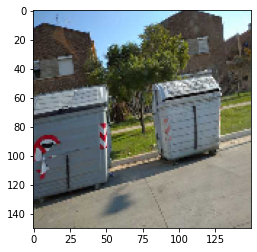

In [ ]:
# melihat hasil dari model yang telah Anda buat pada Notebook. 
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes==0:
    print('bersih')
  else:
    print('kotor')

Saving lingkungan bersih.jpg to lingkungan bersih.jpg
lingkungan bersih.jpg
bersih


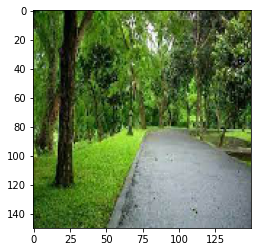

In [ ]:
# melihat hasil dari model yang telah Anda buat pada Notebook. 
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes==0:
    print('bersih')
  else:
    print('kotor')

Saving dirty1.jpg to dirty1.jpg
dirty1.jpg
kotor


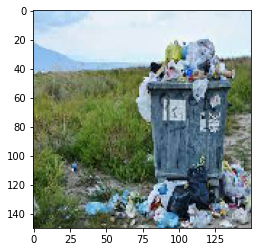

In [ ]:
# melihat hasil dari model yang telah Anda buat pada Notebook. 
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes==0:
    print('bersih')
  else:
    print('kotor')

Saving WhatsApp Image 2021-12-02 at 06.03.15.jpeg to WhatsApp Image 2021-12-02 at 06.03.15.jpeg
WhatsApp Image 2021-12-02 at 06.03.15.jpeg
bersih


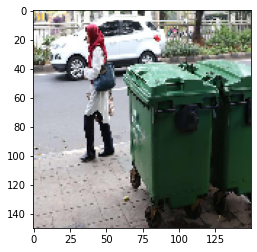

In [ ]:
# melihat hasil dari model yang telah Anda buat pada Notebook. 
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes==0:
    print('bersih')
  else:
    print('kotor')

Saving WhatsApp Image 2021-11-23 at 11.16.36.jpeg to WhatsApp Image 2021-11-23 at 11.16.36.jpeg
WhatsApp Image 2021-11-23 at 11.16.36.jpeg
bersih


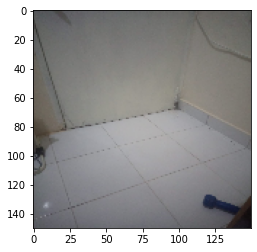

In [ ]:
# melihat hasil dari model yang telah Anda buat pada Notebook. 
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes==0:
    print('bersih')
  else:
    print('kotor')

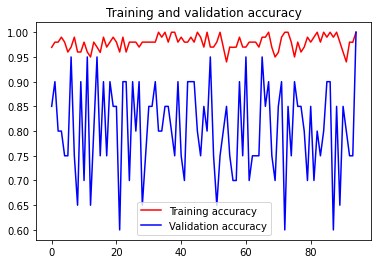

<Figure size 432x288 with 0 Axes>

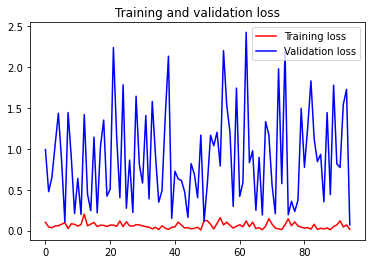

<Figure size 432x288 with 0 Axes>

In [ ]:
# METRIK EVALUSASI
# MEMBUAT PLOT AKURASI dan LOSS TRAINING DAN VALIDATION
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
# Menyimpan Model ke Format TF-Lite
# Mengkonversi Model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan Model
with open('model_deteksi.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpbaq7sfn6/assets


In [ ]:
# SAVE MODEL TO JSON
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()

with open("model_deteksi.json", "w") as json_file:
    json_file.write(model_json)


Model saved


In [ ]:
# Save Model to HDF5
model.save("model_deteksi.h5")

In [ ]:
# save weights to HDF5
model.save_weights("model_weight_deteksi.h5")
print("Model saved")

Model saved
